# CIFAR vectorized LiRA and RMIA examples

This notebook benchmarks vectorised and iterative RMIA and LiRA implementations. 


In [1]:
import os
import sys
import yaml

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt



project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)


## Reusing cached rescaled logits for LiRA
If you already have saved or cached target model rescaled logits, shadow model rescaled logits along with the shadow models in_mask, you can load it from disk and use it to call the scoring methods. The following cell shows a simple example that imports the saved data or generates random example data if no saved data is detected.

If no cached intemediate results are available some random (smoke test) data will be created for the example. 


In [13]:
from leakpro.attacks.mia_attacks.lira import lira_vectorized, lira_iterative

target_dir = "./B/target/intermediates/lira"
shadow_dir = "./B/output/intermediates/lira"

# Paths to the logits and in_mask
shadow_path = Path(shadow_dir + "/rescaled_logits.npy")
inmask_path = Path(shadow_dir + "/in_indices_masks.npy")
target_path = Path(target_dir + "/rescaled_logits.npy")
target_inmask_path = Path(target_dir + "/in_indices_masks.npy")

if shadow_path.exists() and inmask_path.exists() and target_path.exists():
    print("Loading cached logits and membership mask...")
    shadow_logits = np.load(shadow_path)
    shadow_inmask = np.load(inmask_path).astype(bool)
    target_logits = np.load(target_path)
else:   ### thid is for smoke test only, just a toy example 
    print("Cached files not found; generating synthetic logits for a smoke test.")
    rng = np.random.default_rng(2345)
    N, M = 256, 32  # number of audit samples (N) and shadow models (M)
    shadow_logits = rng.normal(size=(N, M))
    target_logits = rng.normal(size=N)
    shadow_inmask = rng.random((N, M)) < 0.5
    

Loading cached logits and membership mask...


In [14]:
%%time
scores_vectorized = lira_vectorized(target_logits=target_logits[:,0], 
                         shadow_logits=shadow_logits,
                         shadow_inmask=shadow_inmask,
                         var_calculation="carlini",
                         online=True,
                         fix_var_threshold=32)

CPU times: user 96 ms, sys: 27.8 ms, total: 124 ms
Wall time: 122 ms


In [15]:
%%time
scores_iterative = lira_iterative(target_logits=target_logits[:,0], 
                         shadow_logits=shadow_logits,
                         shadow_inmask=shadow_inmask,
                         var_calculation="carlini",
                         online=True,
                         fix_var_threshold=32)

Processing audit samples: 100%|██████████| 60000/60000 [00:09<00:00, 6082.67it/s]

CPU times: user 10.3 s, sys: 1.41 s, total: 11.7 s
Wall time: 9.94 s


Computed LiRA scores for 60000 samples.
First five vectorized scores: [ 0.11941167  0.42380977  0.41448921 -0.43304303  0.667075  ]
Computed LiRA scores for 60000 samples.
First five iterative scores: [ 0.11941167  0.42380977  0.41448921 -0.43304317  0.66707478]


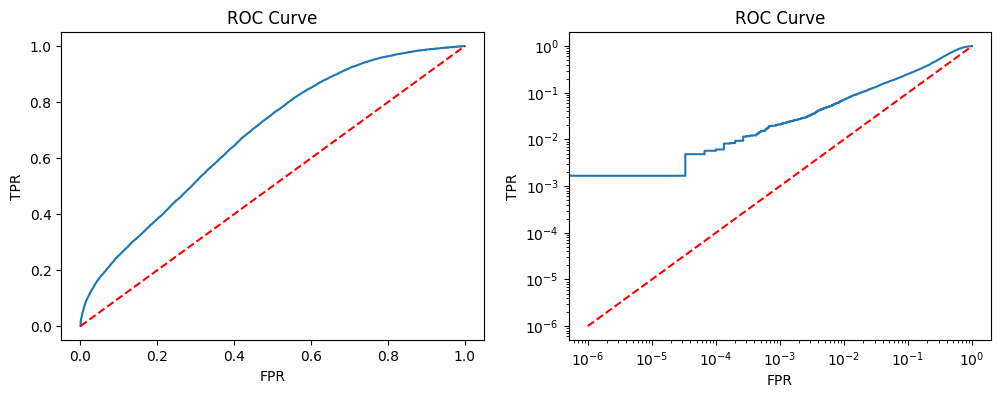

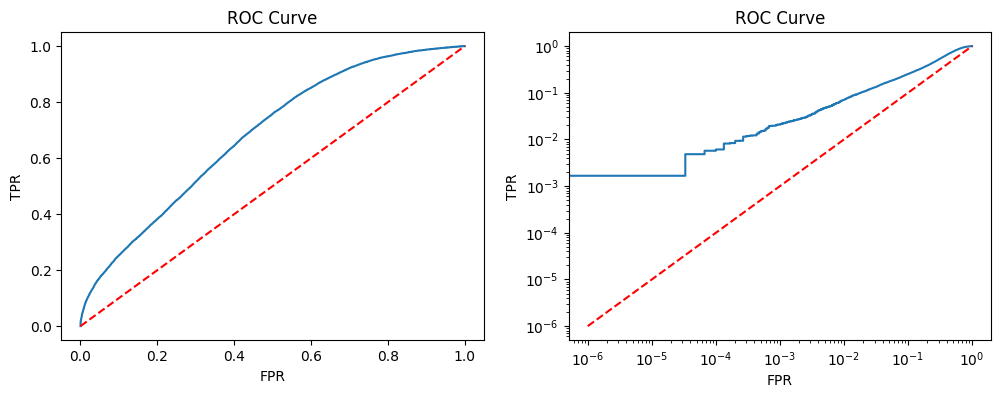

In [16]:
print(f'Computed LiRA scores for {scores_vectorized.shape[0]} samples.')
print('First five vectorized scores:', scores_vectorized[:5])

print(f'Computed LiRA scores for {scores_iterative.shape[0]} samples.')
print('First five iterative scores:', scores_iterative[:5])

# Load or synthesize membership labels for ROC computation
if target_inmask_path.exists():
    membership = np.load(target_inmask_path).astype(bool)
else:
    rng = np.random.default_rng(123)
    membership = rng.random(scores_vectorized.shape[0]) < 0.5

def plot_results(results, labels=None, smarts=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for ax, flag in zip(axs, [True, False]):
        for i, (fpr, tpr) in enumerate(results):
            label = None if labels is None else labels[i]
            smart = '-' if smarts is None else smarts[i]
            if flag:
                ax.plot(fpr, tpr, smart, label=label)
            else:
                ax.loglog(fpr, tpr, smart, label=label)
        if results:
            diag = np.linspace(1e-6 if not flag else 0.0, 1.0, 200)
            ax.plot(diag, diag, 'r--', label='random')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('ROC Curve')
    plt.show()

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(membership.astype(int), scores_vectorized)
plot_results([(fpr, tpr)], labels=['Vectorized LiRA (cached)'])

fpr, tpr, _ = roc_curve(membership.astype(int), scores_iterative)
plot_results([(fpr, tpr)], labels=['Iterative LiRA (cached)'])


## Reusing cached rescaled logits for RMIA
If you already have saved or cached target model ground truth label (GTL) probabilities, shadow model GTL probabilities along with the shadow models in_mask, you can load it from disk and use it to call the scoring methods. The following cell shows a simple example that imports the saved data or generates random example data if no saved data is detected.

If no cached intemediate results are available some random (smoke test) data will be created for the example. 


In [22]:
from leakpro.attacks.mia_attacks.rmia import rmia_vectorised

target_dir = "./B/target/intermediates/rmia"
shadow_dir = "./B/output/intermediates/rmia"

# Paths to the logits and in_mask
shadow_probs_path = Path(shadow_dir + "/gtl_probabilities.npy")
shadow_inmask_path = Path(shadow_dir + "/in_indices_masks.npy")
target_probs_path = Path(target_dir + "/gtl_probabilities.npy")
target_inmask_path = Path(target_dir + "/in_indices_masks.npy")

if shadow_path.exists() and inmask_path.exists() and target_path.exists():
    print("Loading cached probs and membership mask...")
    shadow_probs = np.load(shadow_probs_path)
    shadow_inmask = np.load(shadow_inmask_path).astype(bool)
    target_probs = np.load(target_probs_path)
else:   ### thid is for smoke test only, just a toy example 
    print("Cached files not found; generating synthetic probs for a smoke test.")
    rng = np.random.default_rng(2345)
    N, M = 256, 32  # number of audit samples (N) and shadow models (M)
    shadow_probs = rng.uniform(size=(N, M))
    target_logits = rng.uniform(size=N)
    target_probs = rng.uniform((N, M)) < 0.5
    

Loading cached probs and membership mask...


In [30]:
%%time
scores_using_gpu = rmia_vectorised(target_probs, shadow_probs, shadow_inmask, online=True, 
                                    use_gpu_if_available=True)


Available device: cuda
shadow_gtlprobs (60000, 20)
shadow_inmasks (60000, 20)
ratio_x (60000, 1)
ratio_z (60000, 1)
CPU times: user 155 ms, sys: 17 ms, total: 172 ms
Wall time: 170 ms


In [31]:
%%time
scores_using_cpu = rmia_vectorised(target_probs, shadow_probs, shadow_inmask, online=True, 
                                    use_gpu_if_available=False)


Available device: cpu
shadow_gtlprobs (60000, 20)
shadow_inmasks (60000, 20)
ratio_x (60000, 1)
ratio_z (60000, 1)
CPU times: user 58.1 s, sys: 48.5 s, total: 1min 46s
Wall time: 5.31 s


Computed RMIA scores for 60000 samples.
First five scores using GPU: [0.7198167  0.48075    0.66426665 0.37561667 0.41053334]
Computed RMIA scores for 60000 samples.
First five scores using CPU: [0.7198167  0.48075    0.66426665 0.37561667 0.41053334]


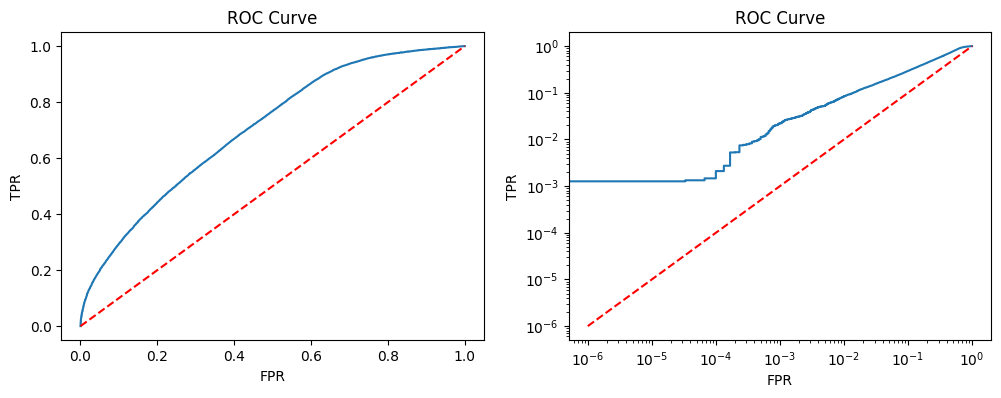

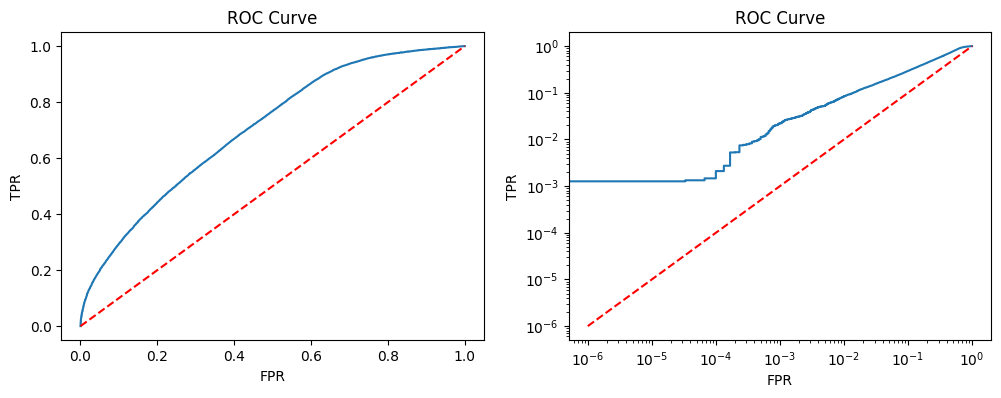

In [32]:
print(f'Computed RMIA scores for {scores_using_gpu.shape[0]} samples.')
print('First five scores using GPU:', scores_using_gpu[:5])

print(f'Computed RMIA scores for {scores_using_cpu.shape[0]} samples.')
print('First five scores using CPU:', scores_using_cpu[:5])

# Load or synthesize membership labels for ROC computation
if target_inmask_path.exists():
    membership = np.load(target_inmask_path).astype(bool)
else:
    rng = np.random.default_rng(123)
    membership = rng.random(scores_vectorized.shape[0]) < 0.5

def plot_results(results, labels=None, smarts=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for ax, flag in zip(axs, [True, False]):
        for i, (fpr, tpr) in enumerate(results):
            label = None if labels is None else labels[i]
            smart = '-' if smarts is None else smarts[i]
            if flag:
                ax.plot(fpr, tpr, smart, label=label)
            else:
                ax.loglog(fpr, tpr, smart, label=label)
        if results:
            diag = np.linspace(1e-6 if not flag else 0.0, 1.0, 200)
            ax.plot(diag, diag, 'r--', label='random')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title('ROC Curve')
    plt.show()

from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(membership.astype(int), scores_using_gpu)
plot_results([(fpr, tpr)], labels=['RMIA using GPU (cached)'])

fpr, tpr, _ = roc_curve(membership.astype(int), scores_using_cpu)
plot_results([(fpr, tpr)], labels=['RMIA using CPU (cached)'])
